[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)

#### based on Fig. 2 from Abade & Albuquerque 2024 (QJRMS)  "_Persistent mixed‐phase states in adiabatic cloud parcels under idealised conditions_"

(work in progress!) # TODO #1656

https://doi.org/10.1002/qj.4775

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.backends import CPU
from PySDM_examples.utils.widgets import display, FloatProgress
from PySDM_examples.Arabas_et_al_2025.commons import FREEZING_CONSTANTS
from PySDM_examples.Abade_and_Albuquerque_2024 import Simulation, Settings

In [3]:
backend = CPU(
    formulae = Formulae(
        constants={
            "bulk_phase_partitioning_exponent": 0.1,
            **FREEZING_CONSTANTS["dust"],
        },
        bulk_phase_partitioning="KaulEtAl2015",
        particle_shape_and_density="MixedPhaseSpheres",
        diffusion_coordinate="WaterMassLogarithm",
        freezing_temperature_spectrum="Niemand_et_al_2012",
        heterogeneous_ice_nucleation_rate="ABIFM",
    ),
    override_jit_flags={"parallel": False}
)

In [4]:
backend.formulae.seed = 0
t_max = 6000 * si.s
dt_out = 125 * si.s
n_realisations = 5
n_sds = (10, 100, 1000) # PAPER: "on the order of 1e6"
timestep = 1 * si.s

display(progbar := FloatProgress(value=1, description='JIT + Bulk', max=1 + 2 * n_realisations * len(n_sds)))

run_args = {
    'nt': int(t_max / timestep),
    'steps_per_output_interval': int(dt_out / timestep)
}

datasets = {
    'Bulk': Simulation(Settings(
        backend=backend,
        timestep=timestep,
        n_sd=1,
        enable_immersion_freezing=False,
        enable_vapour_deposition_on_ice=False,
    )).run(**run_args)
}

homogenous_commons = {
    'timestep': timestep,
    'inp_frac': .5, # PAPER: .1
    'enable_immersion_freezing': True,
    'enable_vapour_deposition_on_ice': True,
}

for singular, label in {True: 'INAS', False: 'ABIFM'}.items():
    for n_sd in n_sds:
        datasets[(key := f'Homogeneous-{label}-{n_sd}')] = {'realisations': []}
        for i in range(n_realisations):
            progbar.description = '...' + key[-5:] + f'-{i}'
            datasets[key]['realisations'].append(
                Simulation(Settings(**homogenous_commons, backend=backend, n_sd=n_sd, singular=singular)).run(**run_args)
            )
            backend.formulae.seed += 1
            progbar.value += 1

FloatProgress(value=1.0, description='JIT + Bulk', max=31.0)

In [5]:
colors = {
    'total': 'black',
    'ice': 'gray',
    'water': 'blue',
}

def plot_setup(ax):
    ax.set_xlabel(r"r (g$\cdot$kg$^{-1}$)")
    ax.set_ylabel('Height (km)')
    ax.set_ylim(.75, 3)
    ax.set_xlim(-.05, 1.15)
    ax.grid()
    
def plot_part(ax, data):    
    for realisation in data['realisations']:
        realisation['total'] = np.asarray(realisation['water']) + np.asarray(realisation['ice'])

    data['mean'] = {}
    for name in ('ice', 'water', 'total', 'height'):
        data['mean'][name] = [
            np.mean([realisation[name][level] for realisation in data['realisations']]) 
            for level in range(len(data['realisations'][0][name]))
        ]
    
    for name in ('ice', 'water', 'total'):
        for realisation in data['realisations']:
            ax.plot(
                in_unit(np.asarray(realisation[name]), si.g / si.kg),
                in_unit(np.asarray(realisation['height']), si.km),
                linestyle='--' if name == 'total' else '-',
                color=colors[name],
                linewidth=.75,
            )
        mean = data['mean']
        ax.plot(
            in_unit(np.asarray(mean[name]), si.g / si.kg),
            in_unit(np.asarray(mean['height']), si.km),
            label=name,
            marker='.',
            color=colors[name],
        )

def plot_bulk(ax, data):
    liquid_fraction = backend.formulae.bulk_phase_partitioning.liquid_fraction(np.asarray(data['T']))
    total_water_mixing_ratio = np.asarray(data['water'])
    for name in ('ice', 'water', 'total'):
        values = {
            'total': total_water_mixing_ratio,
            'ice': (1 - liquid_fraction) * total_water_mixing_ratio,
            'water': liquid_fraction * total_water_mixing_ratio
        }[name]
        ax.plot(
            in_unit(values, si.g / si.kg),
            in_unit(np.asarray(data['height']), si.km),
            label=name,
            marker='.',
            color=colors[name],
            linestyle='--' if name == 'total' else '-'
        )
    ax.legend()

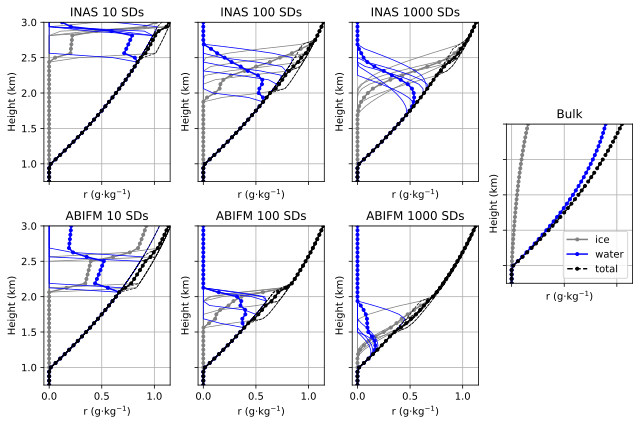

In [6]:
fig, axs = pyplot.subplot_mosaic(
    """ABC.
       ABCG
       DEFG
       DEF.
    """,
    figsize=(9, 6),
    sharex=True,
    sharey=True,
    tight_layout=True,
)
assert len(n_sds) == 3
for ax in axs.values():
    plot_setup(ax)

for label, model, n_sd in (
    ("A", "INAS", n_sds[0]),
    ("B", "INAS", n_sds[1]),
    ("C", "INAS", n_sds[2]),
    ("D", "ABIFM", n_sds[0]),
    ("E", "ABIFM", n_sds[1]),
    ("F", "ABIFM", n_sds[2]),
):
    axs[label].set_title(f"{model} {n_sd} SDs")
    plot_part(axs[label], datasets[f'Homogeneous-{model}-{n_sd}'])

axs["G"].set_title("Bulk")
plot_bulk(axs["G"], datasets['Bulk'])

show_plot('fig_2.pdf')